# **Bin Packing problem via Genetic Algorithm**
#### *Valentinis Alessio - Global and Multi-Objective Optimization Exam - DSAI*

## 1. Introduction to the problem and to the solver


### Problem description
The problem I've chosen to focus on is the famous **Bin Packing** problem. The orgininal statement of the problem stands in having a finite set $I$ of items, with size $s(i), \forall i \in I$, and a positive bin capacity $B$ along with a positive integer $K$. The objective is to find a partition of $I$, such that each partition is entirely contained in one of the $K$ bins.
This problem is computationally *NP-hard*.

However I've decided to study a slight modification of this problem, i.e. given a number $c$ of bins, each containing $b$ items (each of the $c \times b$ items has a different height), find an arrangement of the items such that the maximum height difference between the columns is minimized. The problem can be easilly imagined as having a set of $c$ columns, each of $b$ bricks, with the objective of having the columns' heights as close as possible.
A practical application of this problem can be the placing of different tennants in $c$ machines, each containing $b$ instances, in order to have equal workload in each machine.


### Problem formalization
We said that we have $c$ columns, each of $b$ bricks: so we have available exactly $c \times b$ bricks. Let's denote the set of the available bricks as $$S=\{s_1, \dots, s_{c\times b}\}$$
Let's denote the height of each brick with the function $h: S \to \mathbb{R}$ such that we can denote $$h(s_i) = h_i, \forall i \in \{1, \dots, c\times b\}$$

Having defined these quantities, we can define the height of a single column as $$H(C_i) = \sum_{j \in C_i} h_j$$

In this way, we can define the fitness function as $$f(C_1, \dots, C_c) = H_{\text{max}} - H_{\text{min}}$$
with $C_1, \dots, C_c$ the set of constructed columns, $H_{\text{max}} = \max_{C_1, \dots, C_c} H(C_i)$ and $H_{\text{min}} = \min_{C_1, \dots, C_c} H(C_i)$.


### Genetic Algorithm
In this context, we aim to exploit genetic algorithm to find a sub-optimal solution to the problem. First we have to define the genotype of the algorithm.
- Each individual is represented with a $b \times c$ matrix, having in each entry the height of the corresponding block
- The population is represented in a tensor of dimensions $population\_ size \times b \times c$

We can use as a fitness function the function $f$ defined above, with the objective of minimizing it.

Elitism and tournament selection are exploited to select the best individuals of the population and to create the next generation

The main loop of the algorithm goes as follows:
- **Elitism**: Keep the top *k* individuals of the population according to the fitness, and keep them unchanged.
- **Selection**: Using tournament selection, select the remaining of the population and create a buffer of paired individuals.
- **Crossover**: With probability $p_{cross}$ perform crossover for each pair of parents to obtain two offsprings.
- **Mutation**: With probability $p_{mut}$ perform mutation to each of the obtained individual.
- **New generation**: concatenate the elites and the obtained children to form the new population.

This main loop repeats up to when a predefined number of generations is reached.


#### Specifics on crossover and mutation

**Crossover**:
Note that we have the constraint of uniqueness of bricks to fulfill for each individual. For this reason we can apply two types of crossover:
- *Partially Mapped Crossover*: we select one random column from each individual and swap them. With the map that we create between the two columns, we swap the remaining of the bricks in order to maintain uniqueness.
- *Cycle crossover*: To implement a crossover in a more *uniform* fashion, a canonical cycle crossover routine has been implemented

These two types of crossover will be tested to evaluate efficiency.

**Mutation**:
The mutation operation chosen is very simple. In order again to preserve the constraints on the brick heights, we can't just randomly mutate one brick. So we select two sets of indexes and we swap the corresponding bricks.

Crossover and Mutation happens with fixed probability.


### Example of solution

First impport the solver class

In [1]:
from source.solver import GeneticBinPacker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Define the parameters of the problem and instanciate an element of the class.

In [2]:
columns_per_individual = 5
bricks_per_column = 10

population_size = 20
generations = 500

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

genetic_solver = GeneticBinPacker(population_size, 
                                  mutation_rate, 
                                  crossover_rate, 
                                  generations, 
                                  k_elitism, 
                                  tournament_size, 
                                  set_seed=42)

Solve the problem

In [3]:
genetic_solver.solve(columns_per_individual=columns_per_individual, 
                     bricks_per_column=bricks_per_column, 
                     verbose=True)

100%|██████████| 500/500 [00:00<00:00, 996.91it/s]


Now plot the best individual achieved alongside the whole population per generation.

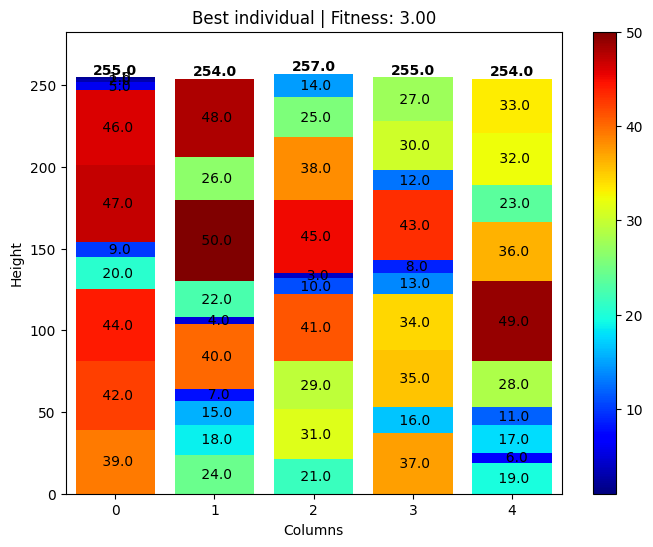

In [4]:
genetic_solver.plot_best_individual(print_values=True)

In [5]:
genetic_solver.plot_population()

interactive(children=(IntSlider(value=1, description='generation', max=500), Output()), _dom_classes=('widget-…

In [ ]:
# Save a GIF figuring the best individuals per generation To see the progress of the solution
genetic_solver.plot_history(path='./plots/')

![Genetic Algorithm Progress](./plots/genetic_bin_packer.gif)

## 2. Study of convergence of the algorithm varying parameters

### Crossover

As my implementation used two types of crossover, it was of my interest to study how the two behave. I'll simulate 10 times the algorithm with same hyperparameters, changing at each simulation the initial population, in order to have an "average" behavior.

In [7]:
columns_per_individual = 5
bricks_per_column = 10

population_size = 50
generations = 500

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

crossovers = ['pmx', 'cycle']

for crossover in crossovers:
	print(f'\n Crossover: {crossover}')
	for sim in range(10):  # 5 simulations
		genetic_solver = GeneticBinPacker(population_size, 
										  mutation_rate, 
										  crossover_rate,
										  generations, 
										  k_elitism, 
										  tournament_size)
		
		genetic_solver.solve(columns_per_individual=columns_per_individual, 
					   		 bricks_per_column=bricks_per_column,
							 crossover=crossover)
		
		for record in genetic_solver.history:
			history_records.append({**{key: value for key, value in record.items() if key not in ['population', 'best_individual']}, 
						  'crossover': crossover, 
						  'simulation': sim,
						  'best_overall': genetic_solver.best_fitness})
			
crossover_df = pd.DataFrame(history_records)


 Crossover: pmx

 Crossover: cycle


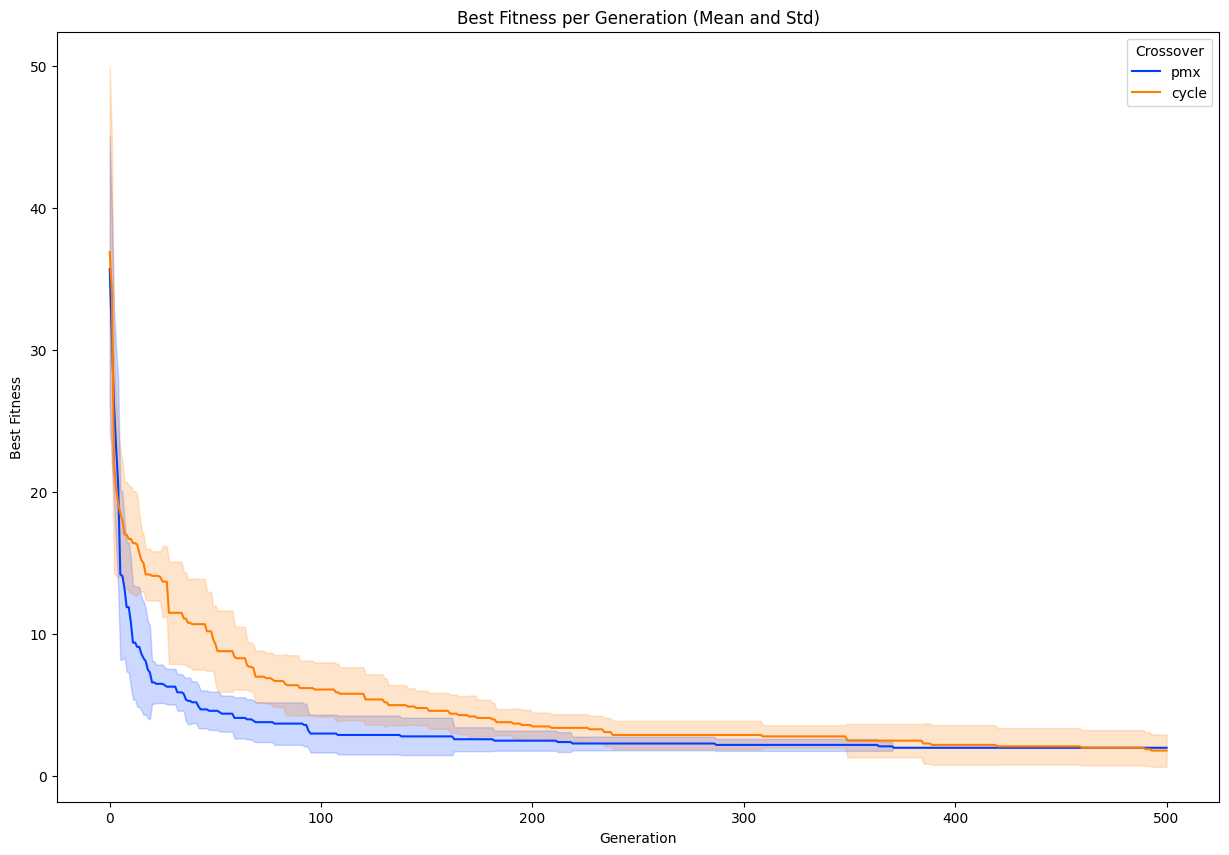

In [8]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=crossover_df,
	x='iteration',
	y='best_fitness',
	hue='crossover',
	errorbar='sd',
	palette='bright'
)

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation (Mean and Std)')
plt.legend(title='Crossover')

plt.savefig('./plots/crossover_comparison.png')
plt.show()


del crossover_df

We can see how in general the *Partialy Mapped Crssover* in this context works overall better, reaching faster lower levels of the fitness. They still reach similar minimums in nearly the same amount of iterations; however, if the objective is sparing generations, stopping earlier, we can see how going for a *pmx* approach guarantees us to reach better fitness.

### Changing population size

In this part I wanted to see how fast the fitness decreases with different population size, to see if we can find a good tradeoff in terms of fitness reached and population size.

In [9]:
columns_per_individual = 5
bricks_per_column = 10

generations = 500

mutation_rate = 0.1
crossover_rate = 0.8

pop_sizes = [10, 20, 50, 100, 150, 200]

history_records = []

for pop_size in pop_sizes:
	print(f'\n Population size: {pop_size}')
	for sim in range(10):  # 10 simulations
		k_elitism = pop_size // 10
		tournament_size = pop_size // 10
		genetic_solver = GeneticBinPacker(pop_size, 
										  mutation_rate, 
										  crossover_rate,
										  generations, 
										  k_elitism, 
										  tournament_size)
		
		genetic_solver.solve(columns_per_individual=columns_per_individual, 
					   		 bricks_per_column=bricks_per_column)
		
		for record in genetic_solver.history:
			history_records.append({**{key: value for key, value in record.items() if key not in ['population', 'best_individual']}, 
									'population_size': pop_size, 
									'simulation': sim})

population_df = pd.DataFrame(history_records)


 Population size: 10

 Population size: 20

 Population size: 50

 Population size: 100

 Population size: 150

 Population size: 200


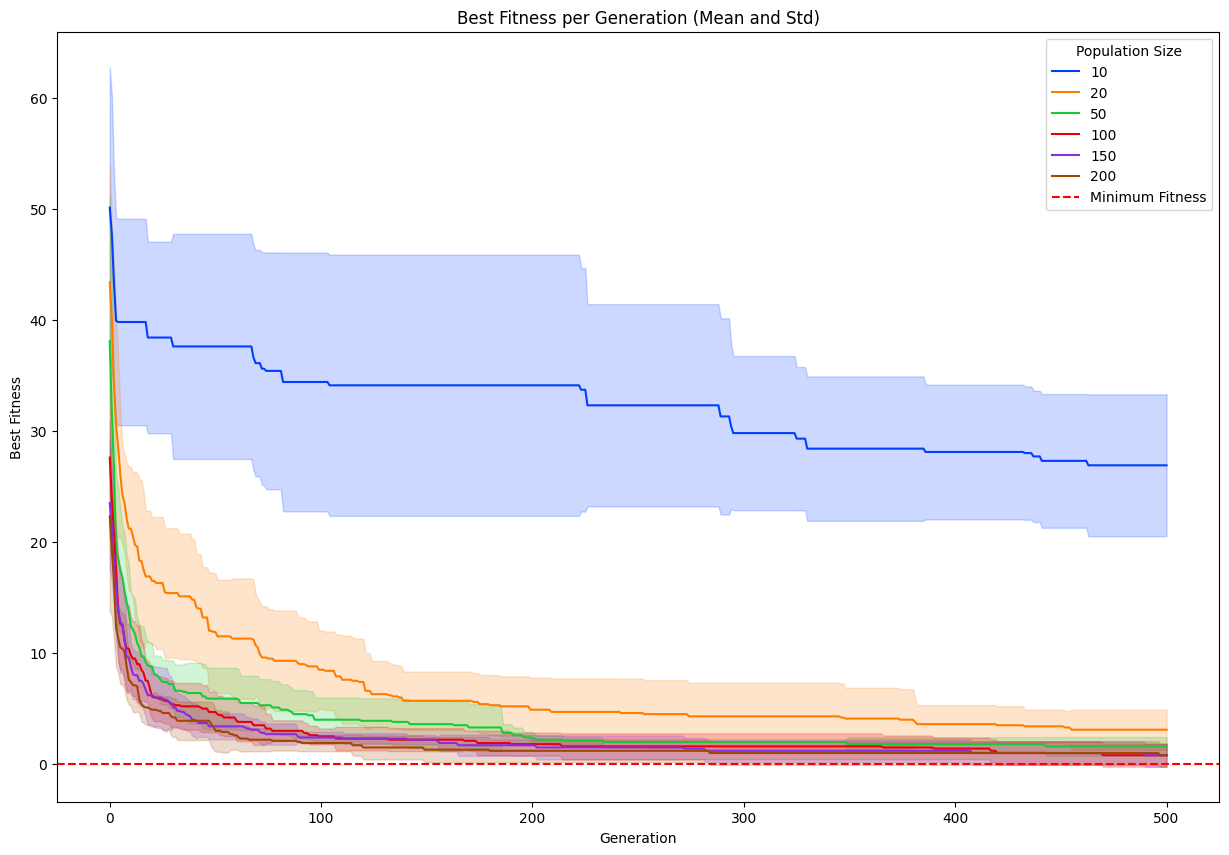

In [10]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=population_df,
    x='iteration',
    y='best_fitness',
    hue='population_size',
    errorbar='sd',
    palette='bright'
)
plt.axhline(population_df['best_fitness'].min(), color='red', linestyle='--', label='Minimum Fitness')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation (Mean and Std)')
plt.legend(title='Population Size')
plt.savefig('./plots/population_comparison.png')
plt.show()


del population_df

We can observe how for a population of 10 individuals is barely enough to halven the fitness value, but it's by far insufficient to try and achieve a pseudo-optimal result in a fair amount of generations.

If we increase the population size, we can observe how even 20 individuals are enough to achieve a good result, but if we want to be greedy, a population size of 50 can achieve the same result in $500$ generations, but reaching a good plateau in the fitness in much fewer iterations.

### Changing the brick heights' distribution

One other study I wanted to conduct was in varying the probability distribution with which the bricks are generated.
Three distributions were analyzed:
- **random generation**: taking the heights as a random permutation of the `range(1, tot_bricks+1)`
- **uniform distribution**: taking the heights from $$Unif(0,10)$$
- **normal distribution**: taking the heights from $$Normal(5,2)$$

However, in order to make this comparison I had to slightly modify the fitness function. In fact, if we simply divide the brick heights by a factor $\lambda$, the ftness value will be also divided by $\lambda$. So we need to take a normalized fitness in order to compare the three methods.

To do this we will divide the fitness evaluation by the average height of the bricks, so the formulation will be $$f_{norm}(C_1, \dots, C_c) = \frac{ H_{\text{max}} - H_{\text{min}}}{\bar h}$$ with $\bar h = \frac{1}{c\times b} \sum_{i=1}^{c\times b} h_i$ mean height of the bricks.


In [11]:
columns_per_individual = 5
bricks_per_column = 10

population_size = 50
generations = 500

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

brick_dists = ['random', 'uniform', 'normal']

history_records = []

for brick_dist in brick_dists:
	print(f'\n Brick distribution: {brick_dist}')
	for sim in range(10):  # 10 simulations
		genetic_solver = GeneticBinPacker(population_size, 
										  mutation_rate, 
										  crossover_rate,
										  generations, 
										  k_elitism, 
										  tournament_size)
		
		genetic_solver.solve(columns_per_individual=columns_per_individual, 
					   		 bricks_per_column=bricks_per_column,
							 brick_dist=brick_dist, 
							 normalize=True)
		
		for record in genetic_solver.history:
			history_records.append({**{key: value for key, value in record.items() if key not in ['population', 'best_individual']}, 
						   'brick_distribution': brick_dist, 
						   'simulation': sim})

brick_dist_df = pd.DataFrame(history_records)


 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal


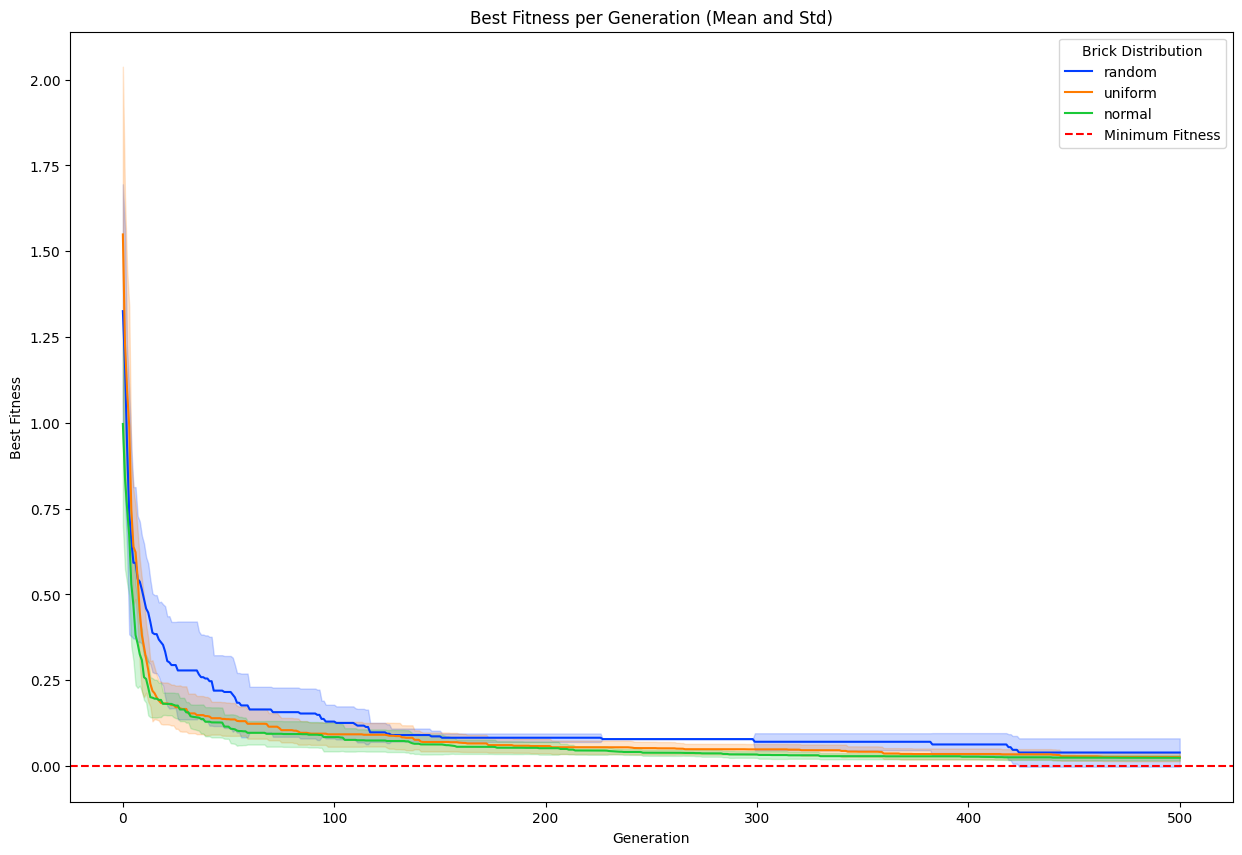

In [12]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=brick_dist_df,
	x='iteration',
	y='best_fitness',
	hue='brick_distribution',
	errorbar='sd',
	palette='bright'
)
plt.axhline(brick_dist_df['best_fitness'].min(), color='red', linestyle='--', label='Minimum Fitness')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation (Mean and Std)')
plt.legend(title='Brick Distribution')
plt.savefig('./plots/brick_distribution_comparison.png')
plt.show()


del brick_dist_df

We can see how in general the *random* distribution takes more time to be optimized: this behavior can be due to the fact that working with integer heights makes the problem much harder.
In the cases of uniform and normal initialization we can see how a good fitness is reached way before, while almost in the totality of the cases we reach almost optimal fitness (this can be observed from the narrow standard deviation intervals in the plot).

### Random vs Uniform vs Normal

Here we want to evaluate how the threee distribution of bricks behave when changing the parameters of the problem, i.e. the number of columns per individual and the number of bricks per column, keeping fixed the number of generations.

In [13]:
import numpy as np

columns_per_individual = 10

population_size = 50
generations = 500

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

brick_dists = ['random', 'uniform', 'normal']
bricks_per_column = np.arange(10, 110, 10)

for bricks_per_column in bricks_per_column:
	print(f'\n Bricks per column: {bricks_per_column}')
	for brick_dist in brick_dists:
		print(f'\n Brick distribution: {brick_dist}')
		for sim in range(10):
			genetic_solver = GeneticBinPacker(population_size, 
									 	      mutation_rate, 
											  crossover_rate,
											  generations, 
											  k_elitism, 
											  tournament_size)
			
			genetic_solver.solve(columns_per_individual=columns_per_individual, 
								 bricks_per_column=bricks_per_column,
								 brick_dist=brick_dist, 
								 normalize=True)
			
			for record in genetic_solver.history:
				history_records.append({**{key: value for key, value in record.items() if key not in ['population', 'best_individual']}, 
							'brick_distribution': brick_dist, 
							'simulation': sim,
							'bricks_per_column': bricks_per_column, 
							'best_overall': genetic_solver.best_fitness})
				

varying_bricks_df = pd.DataFrame(history_records)


 Bricks per column: 10

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 20

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 30

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 40

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 50

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 60

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 70

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 80

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Bricks per column: 90

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution:

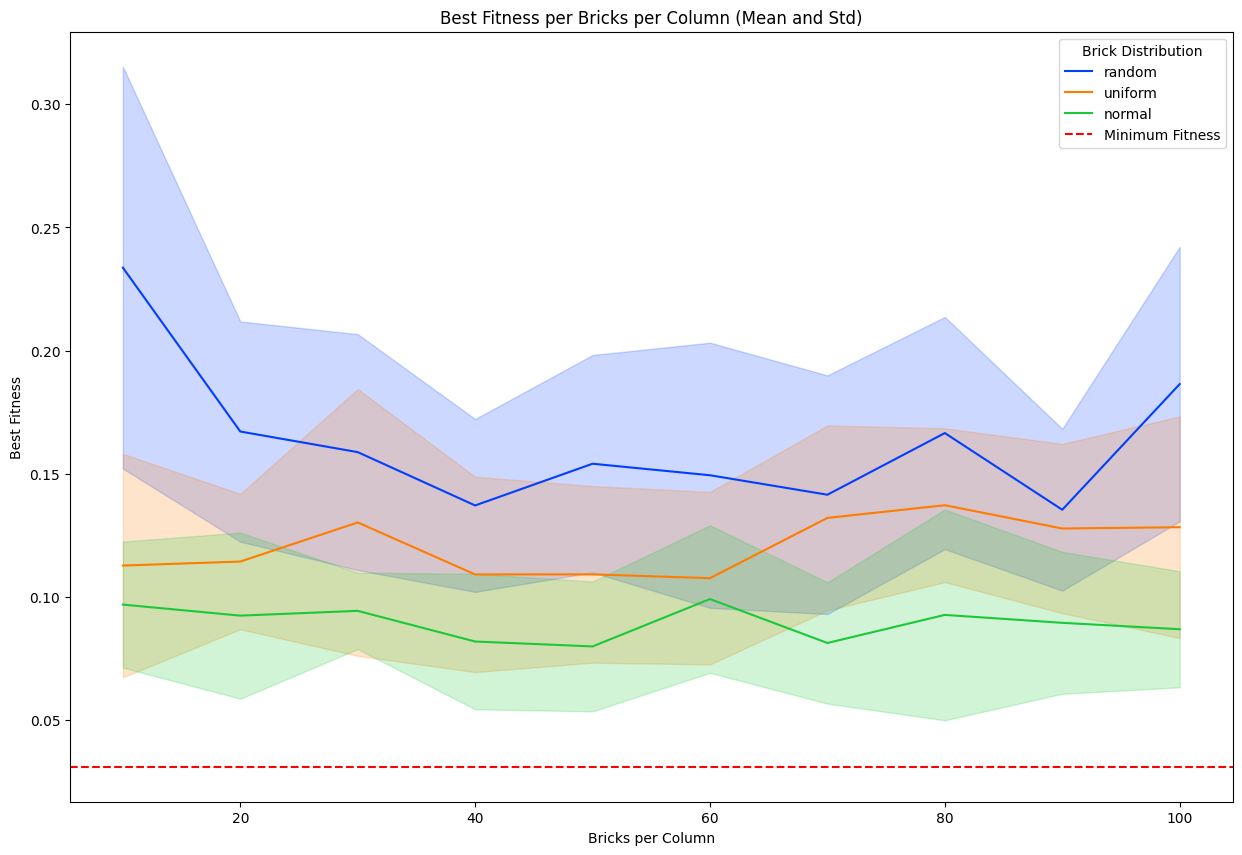

In [14]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=varying_bricks_df,
	x='bricks_per_column',
	y='best_overall',
	hue='brick_distribution',
	errorbar='sd',
	palette='bright'
)
plt.axhline(varying_bricks_df['best_overall'].min(), color='red', linestyle='--', label='Minimum Fitness')
plt.xlabel('Bricks per Column')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Bricks per Column (Mean and Std)')
plt.legend(title='Brick Distribution')
plt.savefig('./plots/bricks_per_column_comparison.png')
plt.show()


del varying_bricks_df

We can see how, keeping fixed the number of columns and varying the number of bricks per columns, the best result achieved stays more or less constant in terms of fitness. This can be seen as having to arrange the bricks in the same amount of columns, we are able to achieve similar results nonetheless.

Now we want to analyze the case when we keep the amount of bricks per column constant and vary the number of columns on which to stack them.

In [15]:
bricks_per_column = 20

population_size = 50
generations = 500

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

brick_dists = ['random', 'uniform', 'normal']
columns_range = np.arange(10, 110, 10)

for columns_per_individual in columns_range:
	print(f'\n Columns per individual: {columns_per_individual}')
	for brick_dist in brick_dists:
		print(f'\n Brick distribution: {brick_dist}')
		for sim in range(5):  # 5 simulations
			genetic_solver = GeneticBinPacker(population_size, 
									 		  mutation_rate, 
											  crossover_rate,
											  generations, 
											  k_elitism, 
											  tournament_size)
			
			genetic_solver.solve(columns_per_individual=columns_per_individual, 
								 bricks_per_column=bricks_per_column,
								 brick_dist=brick_dist, 
								 normalize=True)
			
			for record in genetic_solver.history:
				history_records.append({**{key: value for key, value in record.items() if key not in ['population', 'best_individual']}, 
							'brick_distribution': brick_dist, 
							'simulation': sim,
							'columns_per_individual': columns_per_individual, 
							'best_overall': genetic_solver.best_fitness})
				
varying_columns_df = pd.DataFrame(history_records)


 Columns per individual: 10

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 20

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 30

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 40

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 50

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 60

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 70

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 80

 Brick distribution: random

 Brick distribution: uniform

 Brick distribution: normal

 Columns per individual: 90

 Brick distribution: random

 Bric

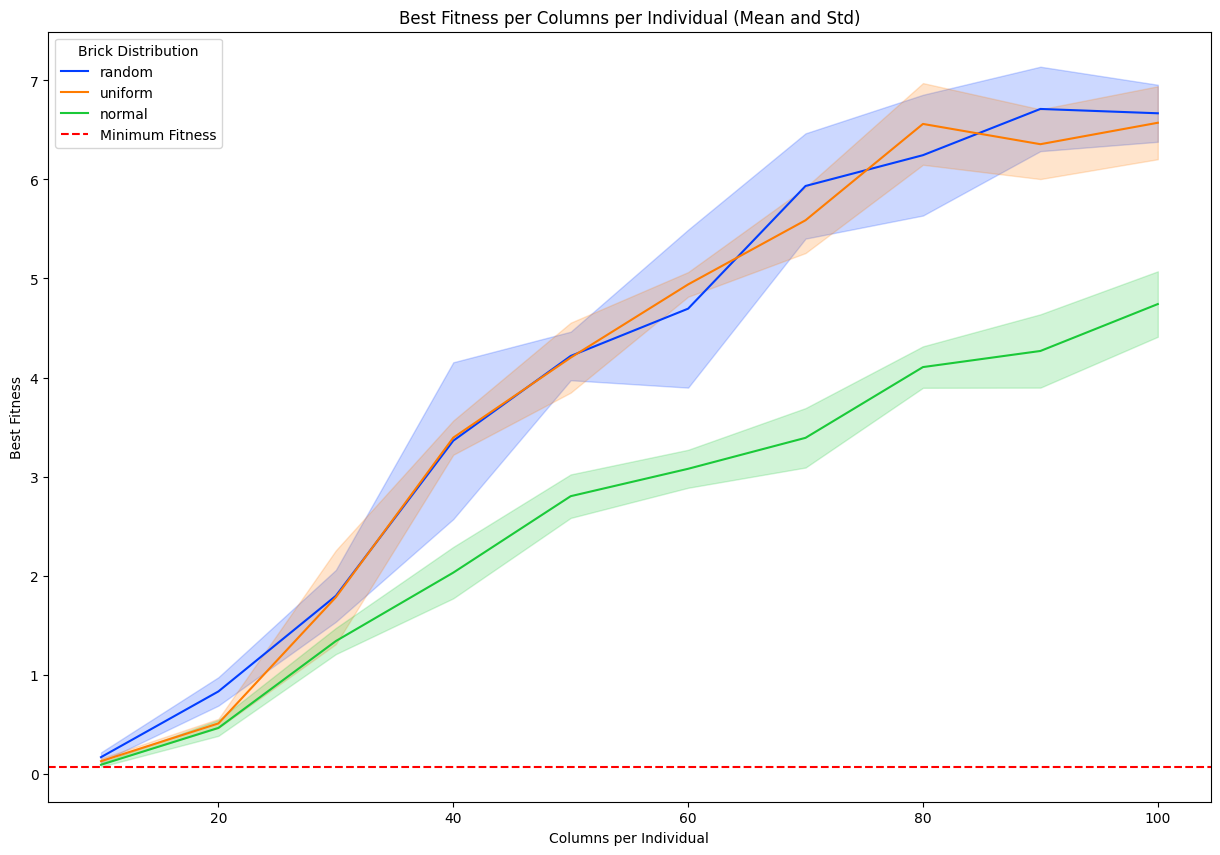

In [16]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=varying_columns_df,
	x='columns_per_individual',
	y='best_overall',
	hue='brick_distribution',
	errorbar='sd',
	palette='bright'
)
plt.axhline(varying_columns_df['best_overall'].min(), color='red', linestyle='--', label='Minimum Fitness')
plt.xlabel('Columns per Individual')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Columns per Individual (Mean and Std)')
plt.legend(title='Brick Distribution')
plt.savefig('./plots/columns_per_individual_comparison.png')
plt.show()


del varying_columns_df

Here we can observe how the average fitness achieved always increases if we increase the nuber of columns. This can be interpreted knowing that by diminishing the brick amount per column, it is more difficult to find an optimal arrangement in these few generations. However the normal distribution seems to behave better, maybe due to the fact that the generated bricks are almost of the same height, so it's easier to arrange them in a way to minimize the difference between the heights.

## 3. Alternative stopping criteria

In this section I'll investigate how we can achieve decent results by adopting some early stopping policies.
This because as the number of generations increase, we expect the fitness ti decrease, or at least not to increase. We would like to stop the algorithm wen we reached a *stable enough* configuration, that allows us to spare computations, being able however to reach a good result.

We'll test these criteria on a toy model, fixing the generation seed for the sake of replicability: in fact, for the conditions I have analyzed, we are **not** guaranteed to stop at the same generation given different runs also on the same problem.

First we define the problem and we make it solve to convergence.

In [17]:
columns_per_individual = 10
bricks_per_column = 20

population_size = 50
generations = 1000

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

genetic_solver = GeneticBinPacker(population_size, 
								  mutation_rate, 
								  crossover_rate,
								  generations, 
								  k_elitism, 
								  tournament_size, 
								  set_seed=True)

genetic_solver.solve(columns_per_individual=columns_per_individual, 
					 brick_dist='uniform', 
					 bricks_per_column=bricks_per_column)

for record in genetic_solver.history:
	history_records.append({
		key: value for key, value in record.items() if key not in ['population', 'best_individual']
	})

vanilla_df = pd.DataFrame(history_records)

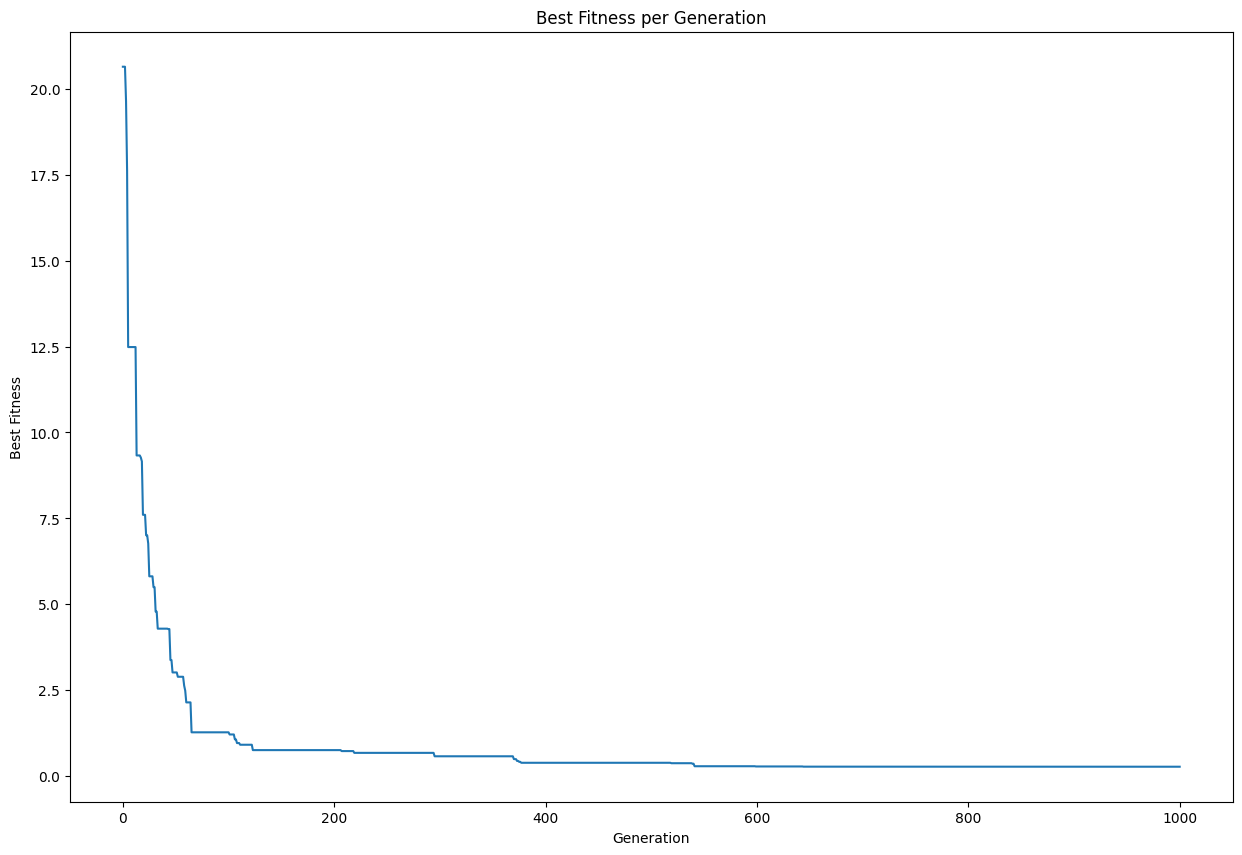

In [18]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=vanilla_df,
	x='iteration',
	y='best_fitness',
	errorbar='sd'
)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')

plt.savefig('./plots/vanilla_genetic_algorithm.png')
plt.show()


del vanilla_df

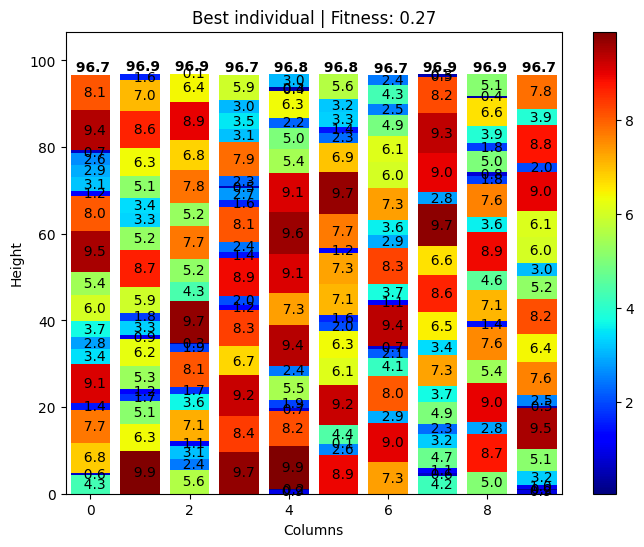

In [19]:
genetic_solver.plot_best_individual(print_values=True, save_path='./plots/best_individual_vanilla_genetic_algorithm.png')

From the previous simuation we can see how in the first 200 generations the fitness drops really quickly, afterwards it reaches a plateau and the improvements are really small.

In practice we would want a good tradeoff between fitness of the solution and time taken to reach it. We want, therefore, to design an alternative stopping criterion for the algorithm.

### Stop for lack of improvement

Here we would like to stop with a probability that is proportional to the improvement of the fitness. For this purpose we can define the improvement at the *i*-th generation as $$\Delta_i = \begin{cases}\Delta_{i-1} \qquad &\text{if} \quad f(i-1) - f(i)=0 \\ f(i-1) - f(i) \qquad &\text{if} \quad f(i-1) - f(i) > 0\end{cases}$$ where $f(i)$ is the best fitness found at the *i*-th generation.

The main idea is that if the last step made a large improvement, a good strategy is to keep searching, as it's very unlikely that we ended up in the best solution; otherwise a good idea is to stop the search to spare computations as we reached a good fitness value for our purposes.

We can formalize this idea with a stopping probability, defined as $$p_{stop}(i) = e^{-\frac{\Delta_i}{T}}$$ with $T \in (0, +\infty)$ being an hyperparameter that regulates how much we want to search rather than saving time and stopping early.

If we try to solve the problem with this termination criterion we obtain

In [20]:
population_size = 20
generations = 1000
columns_per_individual = 10
bricks_per_column = 20

mutation_rate = 0.1
crossover_rate = 0.8
k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

genetic_solver = GeneticBinPacker(population_size, 
								  mutation_rate, 
								  crossover_rate,
								  generations,
								  k_elitism, 
								  tournament_size, 
								  set_seed=True)

genetic_solver.solve_with_termination(columns_per_individual=columns_per_individual, 
									  brick_dist='uniform', 
									  bricks_per_column=bricks_per_column, 
									  termination_criterion='delta', 
									  T=0.005)

for record in genetic_solver.history:
	history_records.append({
		key: value for key, value in record.items() if key not in ['population', 'best_individual']
	})

improvement_df = pd.DataFrame(history_records)

Stopping at iteration 427


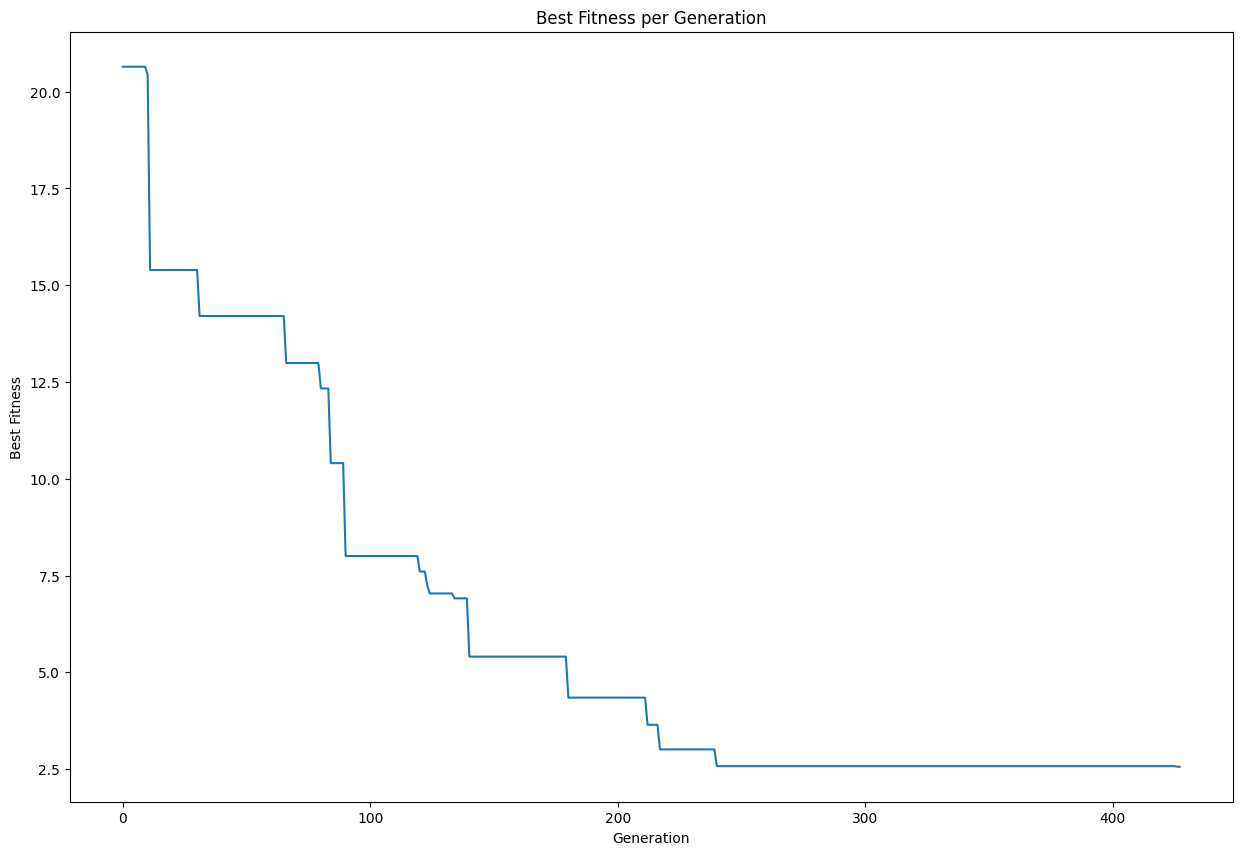

In [21]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=improvement_df,
	x='iteration',
	y='best_fitness'
)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')
plt.savefig('./plots/genetic_algorithm_termination.png')
plt.show()


del improvement_df

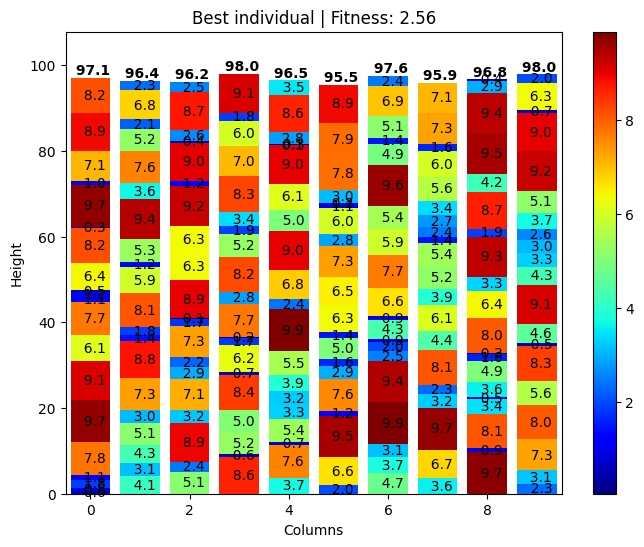

In [22]:
genetic_solver.plot_best_individual(print_values=True, save_path='./plots/best_individual_genetic_algorithm_termination.png')

We can see how with this method we are able to reach a sub-optimal result, being able to spare computations. However this method is strongly dependent on $T$, to which is hard to assign a practical meaning.

The only way is to perform several runs with different values of $T$ and choose the one that satisfies the best our needs.

### Stop for stagnation

Decide to stop when we reach a plateau in the minimum fitness achieved may be effective, but we can still improve. In fact ideally we would like to see if the algorithm has converged to a good solution, so we could check the variability of the fitness within the population. When the variability is small, it can be a good point to stop the evolution.

To formalize this concept we can use the same stopping criterion as before, but redefining the $\Delta_i$ parameter. We will use $$\Delta_i = \frac{1}{pop\_ size} \sqrt{\sum_{k=1}^{pop\_ size} (f(k) - \bar f)^2}$$ where $f(j)$ is the fitness of the *j*-th individual, and $\bar f$ the average fitness of the population.

The parameter $T$ plays the same role as before

In [23]:
population_size = 20
generations = 1000
columns_per_individual = 10
bricks_per_column = 20

mutation_rate = 0.1
crossover_rate = 0.8

k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

# for i in range(10):  # 10 simulations
genetic_solver = GeneticBinPacker(population_size, 
								  mutation_rate, 
								  crossover_rate,
								  generations, 
								  k_elitism, 
								  tournament_size, 
								  set_seed=True)

genetic_solver.solve_with_termination(columns_per_individual=columns_per_individual, 
									  brick_dist='uniform', 
									  bricks_per_column=bricks_per_column, 
									  termination_criterion='std', 
									  T=0.005)

for record in genetic_solver.history:
	history_records.append({
		key: value for key, value in record.items() if key not in ['population', 'best_individual']
	})

stagnation_df = pd.DataFrame(history_records)

Stopping at iteration 874


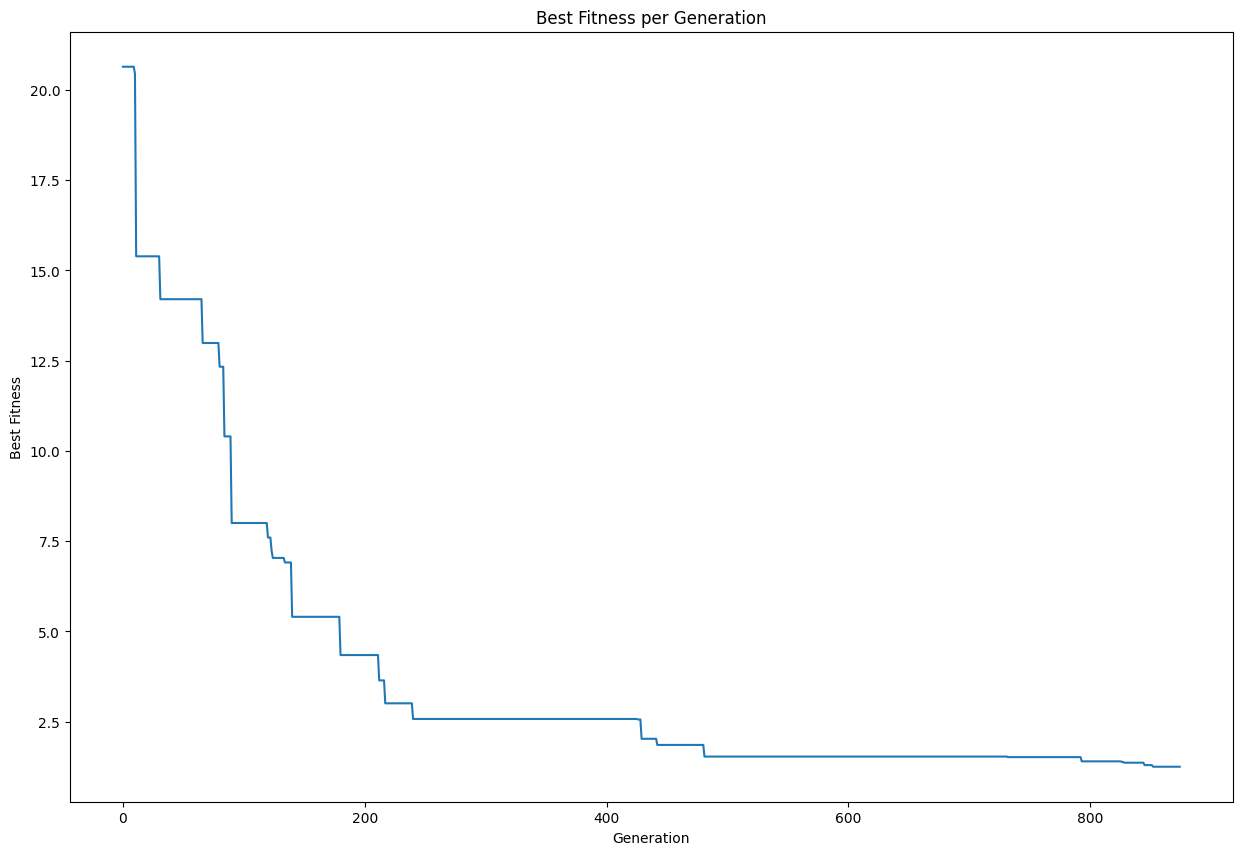

In [24]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=stagnation_df,
	x='iteration',
	y='best_fitness',
)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation')
plt.savefig('./plots/genetic_algorithm_stagnation.png')
plt.show()


del stagnation_df

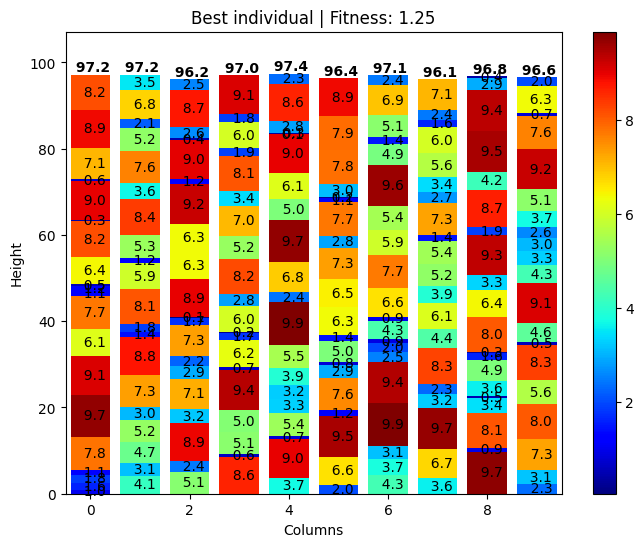

In [25]:
genetic_solver.plot_best_individual(print_values=True, save_path='./plots/best_individual_genetic_algorithm_stagnation.png')

In this case we can see how we stopped before the designed 1000 iterations, but we reached a better solution than before, due to the fact that before stopping we reached a point where the whole population had similar results. 

This time, the parameter $T$ can have a practical meaning: if we want to stop with a high probability (let's say $p_{stop} = 0.5$), having achieved a decent standard deviation within the population (let's say $\sigma = 0.01$), doing the math we will impose $T$ accordingly (in this example $T = 0.014$).

### Dynamic adjustment of T

In all these methods, the parameter T has been taken as fixed throughout the whole evolution. But we can also dymanically calculate it at each iteration as a function of the improvement.
I've opted for a *moving standard deviation* fashion.

In this case we have to:
- keep a buffer of the last `buff_size` $\Delta$ s
- compute the threshold T by updating it as a scaling of the standard deviation of the buffers of deltas with a scaling factor $k \in (0,1)$.

In this way, we can dynamically adjust the threshold, making it:
- increase if the standard deviation of the last deltas is small (this way we move the probability closer to 1)
- decrease if the opposite happens (moving the probability closer to 0)

Doing this, we no more depend on a hard-coded parameter $T$, and we adjust it dynamically depending on the problem.

In [26]:
population_size = 20
generations = 1000
columns_per_individual = 10
bricks_per_column = 20

mutation_rate = 0.1
crossover_rate = 0.8
k = 0.01

k_elitism = population_size // 10
tournament_size = population_size // 10

history_records = []

# for i in range(10):  # 10 simulations
genetic_solver = GeneticBinPacker(population_size, 
								  mutation_rate, 
								  crossover_rate,
								  generations, 
								  k_elitism, 
								  tournament_size, 
								  set_seed=True)

genetic_solver.solve_dynamic(columns_per_individual=columns_per_individual, 
							 termination_criterion='std',
							 brick_dist='uniform', 
							 bricks_per_column=bricks_per_column, 
							 k=k)

for record in genetic_solver.history:
	history_records.append({
		key: value for key, value in record.items() if key not in ['population', 'best_individual']
	})
dynamic_stop_df = pd.DataFrame(history_records)

Stopping at iteration 479 with T=0.0114


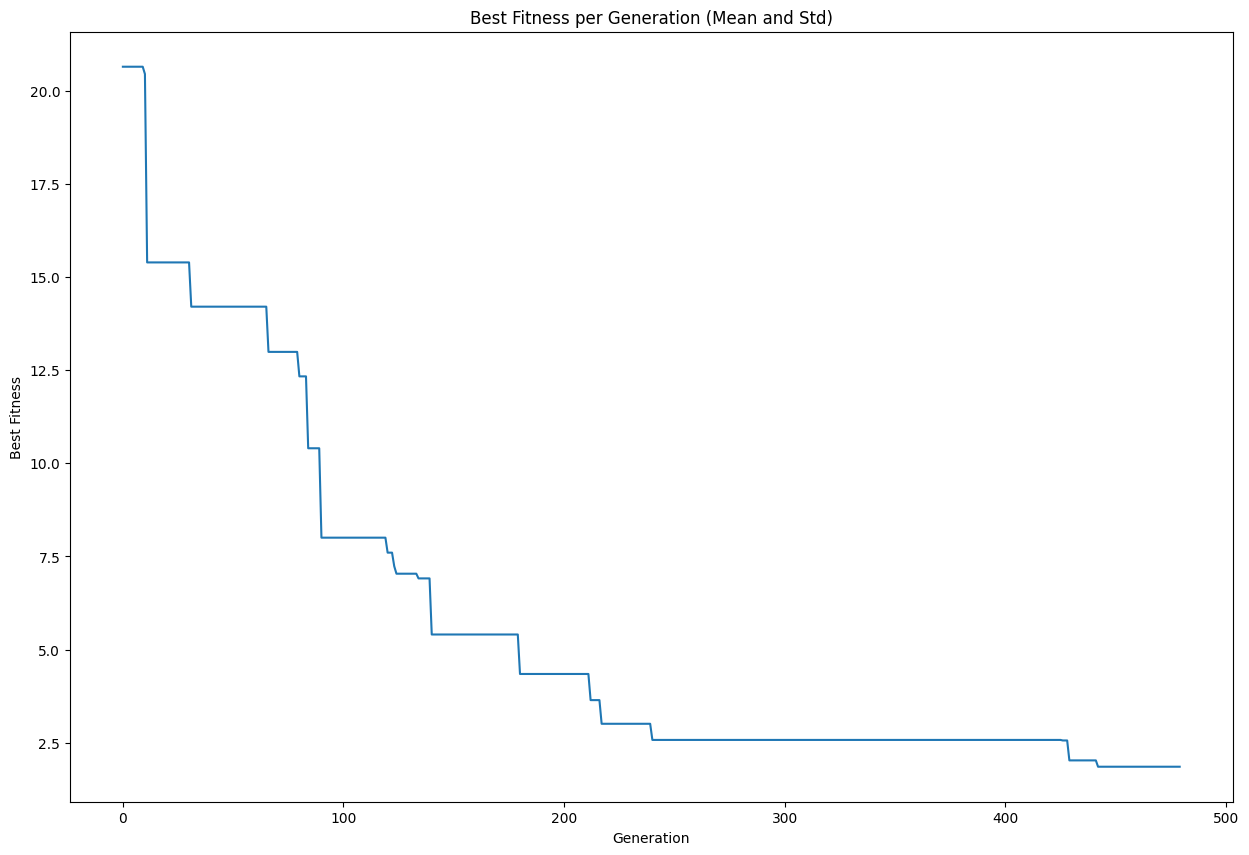

In [27]:
plt.figure(figsize=(15, 10))
sns.lineplot(
	data=dynamic_stop_df,
	x='iteration',
	y='best_fitness',
)

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness per Generation (Mean and Std)')
plt.savefig('./plots/genetic_algorithm_dynamic_stop.png')
plt.show()


del dynamic_stop_df

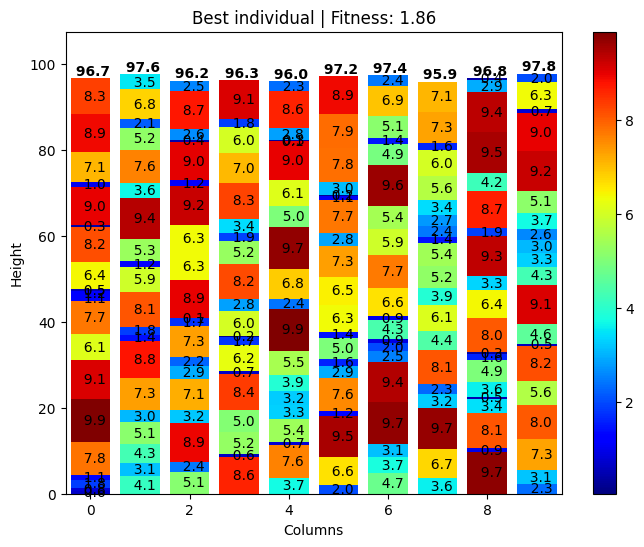

In [28]:
genetic_solver.plot_best_individual(print_values=True, save_path='./plots/best_individual_genetic_algorithm_dynamic.png')

We can see how we have been able to reach similar fitness to the previous case, but sparing about 46% of the generations.